# Exit contract optimization under linear running rewards

In [1]:
#imports and genral algorithm parameter
from matplotlib import pyplot as plt
from scipy.integrate import odeint 
import numpy as np
from scipy.stats import norm
from tqdm.notebook import tqdm

In [2]:
#diffusion parameters
mu_0=-0.1
def mu(x):

    #OU-Prozess
    #return 0.01*x
    return mu_0
sigma_0=0.3
def sigma(x):
    
    return sigma_0
r_0=0.1
def r(x): 
    return r_0

x_0=3
a="-inf"
b='inf'
J_min=-50
J_max=50
dx=0.1
J=np.linspace(J_min,J_max,int((J_max-J_min)/dx+1))

In [3]:
#principle and agent reward structure
n=1
alpha_0=1
alpha_1=1
beta_0=1
beta_1=2

def alpha(x):
    return alpha_1*x

def beta(x):
    return beta_1*x


We now solve the linear second order differential equation
\begin{align}
    \frac{\sigma^2(x)}{2}\Gamma''(x)+\mu(x)\Gamma'(x)-r(x)\Gamma(x)=-(\alpha_1(x)+\beta_1(x))r(x)\quad x\in\mathcal{J}. \label{eqn:Gamma_DGL}
\end{align}
In order to use the scipy function odeint we have to consider the equivalent system of ODE's
\begin{align}
&U'(x)=u(x)\\
&u'(x)=\frac{2}{\sigma^2(x)}\big(-\mu(x)u(x)+r(x)U(x)-(\alpha_1(x)+\beta_1(x))r(x)\big)
\end{align}
Note that we change notation since using Gamma and gamma might be irritating. 

In [5]:
#solving linear second order differential equation
""""
def h_homogeneous(u,x):
    return(u[1],2/sigma(x)**2*(r(x)*u[0]-mu(x)*u[1]))

def h_inhomogeneous(u,x):
    return (u[1],2/sigma(x)**2*(r(x)*u[0]-mu(x)*u[1]-(alpha_1(x)+beta_1(x))*r(x)))


u_0=[0,0]
phi_0=[-1,-1]
psi_0=[1,1]

sol_phi=odeint(h_homogeneous,phi_0,J)
sol_psi=odeint(h_homogeneous,psi_0,J)
sol_i=odeint(h_inhomogeneous,u_0,J)
"""

'"\ndef h_homogeneous(u,x):\n    return(u[1],2/sigma(x)**2*(r(x)*u[0]-mu(x)*u[1]))\n\ndef h_inhomogeneous(u,x):\n    return (u[1],2/sigma(x)**2*(r(x)*u[0]-mu(x)*u[1]-(alpha_1(x)+beta_1(x))*r(x)))\n\n\nu_0=[0,0]\nphi_0=[-1,-1]\npsi_0=[1,1]\n\nsol_phi=odeint(h_homogeneous,phi_0,J)\nsol_psi=odeint(h_homogeneous,psi_0,J)\nsol_i=odeint(h_inhomogeneous,u_0,J)\n'

In [4]:
c_1=-mu_0/sigma_0**2-np.sqrt((mu_0/sigma_0**2)**2+2*r_0/sigma_0**2)
c_2=-mu_0/sigma_0**2+np.sqrt((mu_0/sigma_0**2)**2+2*r_0/sigma_0**2)
A=(alpha_1+beta_1)
B=mu_0*(alpha_1+beta_1)/r_0
print("c1:",c_1,"c2:",c_2,"A:",A,"B:",B)

def phi(x):
    return np.exp(c_1*x)
def psi(x):
    return np.exp(c_2*x)
def Gamma(x):
    return A*x+B

c1: -0.7481333922979456 c2: 2.9703556145201677 A: 3 B: -3.0000000000000004


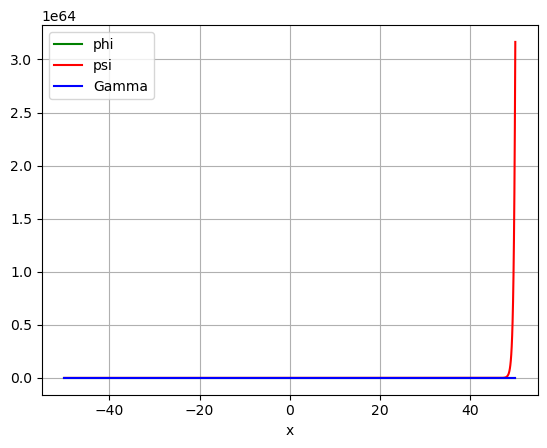

In [5]:
plt.plot(J, phi(J), 'g', label='phi')
plt.plot(J, psi(J), 'r', label='psi')
plt.plot(J, Gamma(J), 'b', label='Gamma')
plt.legend(loc='best')
plt.xlabel('x')
plt.grid()
plt.show()

In [6]:
dt=0.01
T=10

In [7]:
c_1=-mu_0/sigma_0**2-np.sqrt((mu_0/sigma_0**2)**2+2*r_0/sigma_0**2)
c_2=-mu_0/sigma_0**2+np.sqrt((mu_0/sigma_0**2)**2+2*r_0/sigma_0**2)
A=(alpha_1+beta_1)
B=mu_0*(alpha_1+beta_1)/r_0
def Gamma(x):
        return A*x+B
if A>=0:
    def gamma(x):
        return -(Gamma(x)+A/c_1)/(alpha_0+beta_0)
    x_min=-(alpha_0+beta_0)*n/A-B/A-1/c_1
    x_max=-B/A-1/c_1
else:
    def gamma(x):
        return Gamma(x)-A/c_2

In [8]:
def simulate_W(T,dt,N):
    '''
    @input: steps - number of timessteps
            
    @output: W - realisation of a Brownian motion
    '''
    steps=round(T/dt)+1
    #simuliert die Inkremente der Brownschen Bewegung
    dW = norm.rvs(size = (steps,N), scale = np.sqrt(dt))
    dW[0]=np.zeros((N,))
    W = np.cumsum(dW, axis = 0)
    return W

In [9]:
def simulate(Tstart,Tend,dt,N,L_0,x_0,mu_0,sigma_0,r_0,gamma):
    
    steps=round((Tend-Tstart)/dt+1)
    
    W=simulate_W(Tend-Tstart,dt,N)
    times=np.linspace(0,Tend-Tstart,steps).reshape(steps,1)
    X=x_0+mu_0*times+sigma_0*W
    sup_gamma=np.maximum.accumulate(gamma(X))
    L=np.minimum(np.maximum(sup_gamma,np.full((steps,1),L_0)),np.full((steps,1),1))
    L[0]=L_0
    return W,X,L

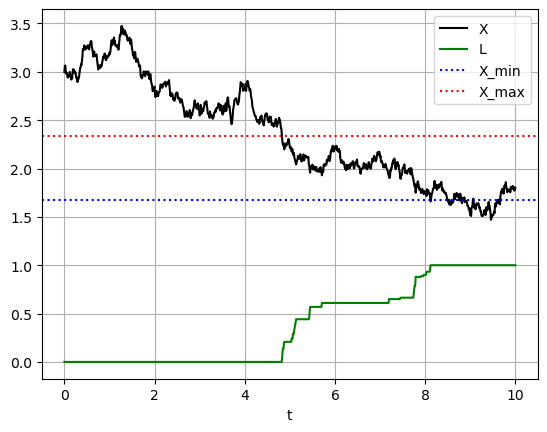

In [10]:
W,X,L=simulate(0,T,dt,1,0,x_0,mu_0,sigma_0,r_0,gamma)
times=np.linspace(0,T,round((T)/dt+1))

plt.plot(times, X, 'black', label='X')
#plot as step function
plt.plot(times, L, 'g', label='L')

plt.axhline(y = x_min, color = 'b', linestyle = 'dotted',label='X_min')
plt.axhline(y = x_max, color = 'r', linestyle = 'dotted',label='X_max')

plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

In [14]:
N=1000
Tmax=100
def approx_Y(t,Tmax,dt,N,x_0,m_0,sigma_0,r_0,gamma):
    return None
Y=[]
for (step,t) in enumerate(tqdm(times)):
    if step%1==0:
        steps_to_Tmax=round((Tmax)/dt+1)
        #print((Tmax)/dt+1,steps)
        times_to_Tmax=np.linspace(t,Tmax+t,steps_to_Tmax)#.reshape((steps_to_Tmax,1))
        Lm=simulate(t,Tmax+t,dt,N,L[step],X[step],mu_0,sigma_0,r_0,gamma)[2]
        #print(Lm.shape,times_to_Tmax.shape)
        L_mean=1/N*np.sum(Lm,axis=1)
        integral=np.sum(r_0*np.exp(-r_0*times_to_Tmax)*L_mean*dt,axis=0)+L_mean[-1]*np.exp(-r_0*(t+Tmax))
        if L_mean[-1]!=1:
            print(L_mean[-1])
        #print(integral.shape)
        #expectation=1/N*np.sum(integral)
        Y.append(beta_0*(integral)+beta_1*np.exp(-r_0*t)*(mu_0*t+mu_0/r_0+sigma_0*W[step]))
    else:
        Y.append(Y[-1])

  0%|          | 0/1001 [00:00<?, ?it/s]

0.9999538893758374
0.999
0.999664975670591
0.9999688778617659
0.9998484311820407
0.9999550802270438
0.9997427623481149
0.999
0.9998986724148998
0.999497310915908
0.9993329496119515
0.9991819052194476
0.999
0.9987371954399878
0.9997766700268267
0.999
0.999
0.998411792071291
0.9995149175239224
0.9993139034051143
0.9997167584543386
0.999
0.9994472821999504
0.999
0.9993606862602515
0.9999217078754417
0.9990384502358366
0.999
0.998
0.9996252428839892
0.9998481013203911
0.9991667760523585
0.9996366710898227
0.9998551785180474
0.999992521878173
0.9991668976418414
0.9992610747303314
0.9996163362354641
0.9999153691225166
0.999279327848691
0.9984121862839579
0.9989007872095349
0.9970252211650408
0.9994962899614517
0.999
0.999
0.999
0.998
0.9996028869359631
0.9994212468474691
0.999
0.9997273631776936
0.9991783605719429
0.9994516179473669
0.9975699273184357
0.9992496827721673
0.9994972403778438
0.9996325099772926
0.9981988059200132
0.999
0.999
0.999
0.9991180953613044
0.9992171900496658
0.99995486

True True


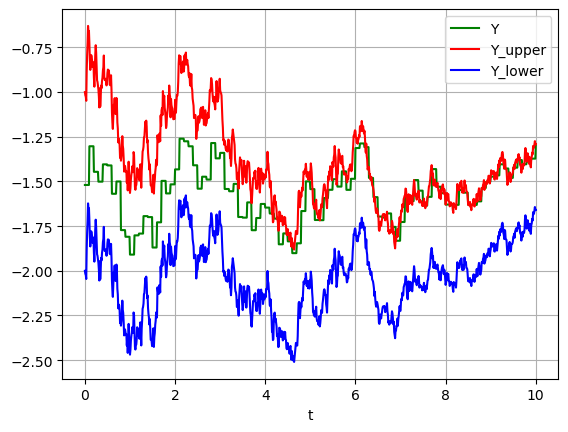

In [37]:
#plt.plot(times, X, 'black', label='X')
#plt.plot(times, L, 'g', label='L')
Y=np.array(Y)
plt.plot(times, Y, 'g', label='Y')
t=times.reshape(times.shape[0],1)
Y_upper=beta_0*np.exp(-r_0*t)+beta_1*np.exp(-r_0*t)*(mu_0*t+mu_0/r_0+sigma_0*W)
Y_lower=beta_1*np.exp(-r_0*t)*(mu_0*t+mu_0/r_0+sigma_0*W)
print(Y_upper.all()>=Y.all(),Y_lower.all()<=Y.all())
plt.plot(times, Y_upper, 'red', label='Y_upper')
plt.plot(times, Y_lower, 'blue', label='Y_lower')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

0.5